# Explainer notebook
This notebook answers the following questions (in the Table of Contents) related to our final assignment in **Social data analysis and visualization (02806)** Spring 2024.

The website with our visualizations and accompanying text can be found on: [Medium](https://lenkaotap.medium.com/6d19502c1225)    

The website for the first part of this assignment can be found here : [Project Assignment A](https://clbokea.github.io/)

Close to deadline note: This grouup started as two group mates, but as the project went along, the group turned into a one woman standing. Hence, sometimes in the description, we use "we" and sometimes, I use "I".

## Table of Contents
* Motivation
    * What is your dataset?
    * Why did you choose this/these particular dataset(s)?
    * What was your goal for the end user's experience?
* Basic stats
    * Write about your choices in data cleaning and preprocessing
    * Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.
* Data Analysis
    * Describe your data analysis and explain what you've learned about the dataset.
    * If relevant, talk about your machine-learning.
    * Genre. Which genre of data story did you use?
    * Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?
    * Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?
* Visualizations.
    * Explain the visualizations you've chosen.
    * Why are they right for the story you want to tell?
* Discussion. 
    * What went well?,
    * What is still missing? What could be improved?, Why?
* Contributions. 

In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd
import os
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', 500)


## Motivation

### What is your dataset?

Most of the data consists of data collected from a Garmin watch worn on the wrist for the past 3-4 years by yje subject Lenka Otap. 

* Garmin watch health data (stress levels, resting heart rate)
* Garmin watch activities (running) data
* Garmin watch sleep data

Additionally, there is personal data from check-ins of emotions using ([HowWeFeelEmotions](https://howwefeel.org/)) for the past 10 months and flagged days for teaching and sick days, as they became relevant for our exploration.

* Data on sick days and lecturing days
* Tracked emotions from HowWeFeelEmotions app

The data retrievment and exploration process was not linaer. First we exported garmin data from their webpage [Garmin Connect](https://sso.garmin.com/portal/sso/en-US/sign-in?clientId=ACCOUNT_MANAGEMENT_CENTER&service=https%3A%2F%2Fwww.garmin.com%2Fen-US%2Faccount%2Fdatamanagement%2Fexportdata%2F) (requires a login), but the data was limited. 

Used data from here was found in the folder DI_CONNECT and subfolders DI-Connect-Aggregator and DI-Connect-Wellnes.

DI-Connect-Aggregator contains various daily measurements, including nested json files (stress scores and body battery during the day). For this project, we didn't look into scores during the day, only the average daily scores.

DI-Connect-Wellnes includes sleep data (total sleep, rem, light and deep sleep, awake time during sleep), and biometric sich as vo2max.

Activies are not found in the exported data, and can instead be downloaded directly from the Garmin Connect page, but only a few at a time, and every time I tried to load all my activies in the page, it times out a couple of years in. Hence, we didn't look mich at activies until later.

In [5]:
garmin_base_dir = "../files/Garmin_20241403/DI_CONNECT"

# Files
#  DI-Connect-Aggregator
#  DI-Connect-Welness
# Find activities?

# Function to load JSONs and combine them into a filtered DataFrame
def load_and_filter_json(base, file, substr, start_year=2020):
    all_dfs = []
    path = os.path.join(base, file)
    for root, _, files in os.walk(path):
        json_files = [f for f in sorted(files) if f.endswith('.json') and substr in f]
        for file in json_files:
            with open(os.path.join(root, file), 'r') as f:
                data = json.load(f)
#            df = pd.DataFrame(data) if isinstance(data, list) else pd.DataFrame([data])
            df = pd.json_normalize(data, sep='_')
            all_dfs.append(df)


    # Combining and filtering the data
    if all_dfs:
        full_df = pd.concat(all_dfs, ignore_index=True)

        # Check if 'metaData_calendarDate' column exists before trying to access it
        if 'metaData_calendarDate' in full_df.columns:
            full_df['calendarDate'] = pd.to_datetime(full_df['metaData_calendarDate'])
        elif 'calendarDate' in full_df.columns:
            full_df['calendarDate'] = pd.to_datetime(full_df['calendarDate'])
        else:
            print("No 'calendarDate' column found in data")
            return pd.DataFrame()  # Return empty DataFrame if column is missing
        
        full_df['calendarDate'] = pd.to_datetime(full_df['calendarDate'])
        full_df = full_df.loc[full_df['calendarDate'].dt.year >= start_year]#, columns_of_interest]
        return full_df
    return pd.DataFrame()  # Return empty DataFrame if no data was loaded
    

start_year = 2020

# DataFrames from json-files, combined
aggregator_df = load_and_filter_json(garmin_base_dir, "DI-Connect-Aggregator", 'UDS', start_year)
sleep_df = load_and_filter_json(garmin_base_dir, "DI-Connect-Wellness", 'sleepData', start_year)
bio_df = load_and_filter_json(garmin_base_dir, "DI-Connect-Wellness", 'userBioMetrics', start_year)

In [6]:
print(aggregator_df.columns)
aggregator_df

Index(['userProfilePK', 'calendarDate', 'uuid', 'durationInMilliseconds',
       'consumedKilocalories', 'remainingKilocalories',
       'includesCalorieConsumedData', 'version', 'totalKilocalories',
       'activeKilocalories', 'burnedKilocalories', 'totalDistanceMeters',
       'includesWellnessData', 'includesActivityData', 'bmrKilocalories',
       'wellnessKilocalories', 'wellnessTotalKilocalories',
       'wellnessActiveKilocalories', 'totalSteps', 'dailyStepGoal',
       'wellnessDistanceMeters', 'wellnessStartTimeGmt', 'wellnessEndTimeGmt',
       'wellnessStartTimeLocal', 'wellnessEndTimeLocal', 'highlyActiveSeconds',
       'activeSeconds', 'moderateIntensityMinutes', 'vigorousIntensityMinutes',
       'floorsAscendedInMeters', 'floorsDescendedInMeters',
       'userIntensityMinutesGoal', 'userFloorsAscendedGoal', 'minHeartRate',
       'maxHeartRate', 'restingHeartRate', 'currentDayRestingHeartRate',
       'restingHeartRateTimestamp', 'includesSingleMeasurement',
       'in

,userProfilePK,calendarDate,uuid,durationInMilliseconds,consumedKilocalories,remainingKilocalories,includesCalorieConsumedData,version,totalKilocalories,activeKilocalories,burnedKilocalories,totalDistanceMeters,includesWellnessData,includesActivityData,bmrKilocalories,wellnessKilocalories,wellnessTotalKilocalories,wellnessActiveKilocalories,totalSteps,dailyStepGoal,wellnessDistanceMeters,wellnessStartTimeGmt,wellnessEndTimeGmt,wellnessStartTimeLocal,wellnessEndTimeLocal,highlyActiveSeconds,activeSeconds,moderateIntensityMinutes,vigorousIntensityMinutes,floorsAscendedInMeters,floorsDescendedInMeters,userIntensityMinutesGoal,userFloorsAscendedGoal,minHeartRate,maxHeartRate,restingHeartRate,currentDayRestingHeartRate,restingHeartRateTimestamp,includesSingleMeasurement,includesContinuousMeasurement,includesAllDayPulseOx,includesSleepPulseOx,source,minAvgHeartRate,maxAvgHeartRate,lowestSpo2Value,latestSpo2Value,latestSpo2ValueReadingTimeGmt,latestSpo2ValueReadingTimeLocal,allDayStress_userProfilePK,allDayStress_calendarDate,allDayStress_aggregatorList,bodyBattery_userProfilePK,bodyBattery_calendarDate,bodyBattery_chargedValue,bodyBattery_drainedValue,bodyBattery_bodyBatteryVersion,bodyBattery_bodyBatteryStatList,hydration_userProfilePK,hydration_calendarDate,hydration_valueInML,hydration_activityIntakeInML,hydration_goalInML,hydration_capped,hydration_sweatLossInML,hydration_adjustedGoalInML,hydration_lastEntryTimestampLocal,respiration_userProfilePK,respiration_calendarDate,respiration_avgWakingRespirationValue,respiration_highestRespirationValue,respiration_lowestRespirationValue,respiration_latestRespirationValue,respiration_latestRespirationTimeGMT,averageSpo2Value,netCalorieGoal,dailyTotalFromEpochData,restingCaloriesFromActivity,isVigorousDay
14,86607424,2020-06-18,18de2ff7644a48d3bbc44785a8d746ad,86400000,NaN,1923.0,False,74280002,1923.0,446.0,NaN,10037.0,True,True,1477.0,1923.0,1923.0,446.0,13987.0,10000.0,10037.0,2020-06-17T22:00:00.0,2020-06-18T22:00:00.0,2020-06-18T00:00:00.0,2020-06-19T00:00:00.0,7480.0,1476.0,11.0,0.0,47.313,41.145,180.0,10.0,64.0,128.0,68.0,68.0,1.592518e+12,True,False,False,False,0.0,65.0,121.0,95.0,95.0,2020-06-18T20:14:00.0,2020-06-18T22:14:00.0,86607424.0,2020-06-18,"[{'type': 'TOTAL', 'averageStressLevel': 40, '...",86607424.0,2020-06-18,13.0,38.0,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",86607424.0,2020-06-18,0.0,0.0,2129.0,False,302.0,2431.0,2020-06-18T15:20:37.0,86607424.0,2020-06-18,14.0,23.0,4.0,17.0,2020-06-18T22:00:00.0,NaN,NaN,NaN,NaN,NaN
15,86607424,2020-06-19,94fe702aadb840e79b86f5e430e35880,86400000,NaN,1885.0,False,63840002,1885.0,408.0,NaN,9329.0,True,True,1477.0,1885.0,1885.0,408.0,12455.0,10000.0,9329.0,2020-06-18T22:00:00.0,2020-06-19T22:00:00.0,2020-06-19T00:00:00.0,2020-06-20T00:00:00.0,5162.0,2430.0,2.0,10.0,31.366,76.475,180.0,10.0,55.0,160.0,64.0,59.0,1.592604e+12,True,False,True,False,0.0,56.0,158.0,85.0,97.0,2020-06-19T22:00:00.0,2020-06-20T00:00:00.0,86607424.0,2020-06-19,"[{'type': 'TOTAL', 'averageStressLevel': 20, '...",86607424.0,2020-06-19,86.0,38.0,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",86607424.0,2020-06-19,0.0,0.0,2129.0,False,467.0,2596.0,2020-06-19T16:27:16.0,86607424.0,2020-06-19,13.0,21.0,6.0,20.0,2020-06-19T22:00:00.0,96.0,NaN,NaN,NaN,NaN
16,86607424,2020-06-20,734de901672a4d10834648af9183a61e,86400000,NaN,2456.0,False,82320003,2456.0,975.0,NaN,21728.0,True,True,1481.0,2456.0,2456.0,975.0,26379.0,10000.0,21728.0,2020-06-19T22:00:00.0,2020-06-20T22:00:00.0,2020-06-20T00:00:00.0,2020-06-21T00:00:00.0,9014.0,2798.0,20.0,88.0,60.259,66.790,180.0,10.0,53.0,159.0,62.0,58.0,1.592690e+12,True,False,True,True,0.0,54.0,156.0,84.0,94.0,2020-06-20T22:00:00.0,2020-06-21T00:00:00.0,86607424.0,2020-06-20,"[{'type': 'TOTAL', 'averageStressLevel': 15, '...",86607424.0,2020-06-20,74.0,71.0,1.0,"[{'bodyBatteryStatType': 'HIGHEST', 'statsValu...",86607424.0,2020-06-20,0.0,0.0,2129.0,False,988.0,3117.0,2020-06-20T15:54:58.0,86607424.0,2020-06-20,12.0

Later, we found a more effective way of downloading real-time data by using the garmin connect library:

In [7]:
from garminconnect import (
    Garmin,
    GarminConnectConnectionError,
    GarminConnectTooManyRequestsError,
    GarminConnectAuthenticationError,
)

The further code for this requires a user login and password in the code, which I, despice my "Shut up and take my data" philosophy, will not be sharing here.

In [9]:
import datetime
from datetime import date
import calendar
import pandas as pd
from tqdm import tqdm
import plotly.graph_objects as go

YOUR_EMAIL = "l****@o****.dk"
YOUR_PASSWORD = "************"


"""
Initialize Garmin client with credentials
Only needed when your program is initialized
"""
try:
    client = Garmin(YOUR_EMAIL, YOUR_PASSWORD)
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client init: %s" % err)
    quit()
except Exception:  # pylint: disable=broad-except
    print("Unknown error occured during Garmin Connect Client init")
    quit()



In [10]:
"""
Login to Garmin Connect portal
Only needed at start of your program
The libary will try to relogin when session expires
"""
try:
    client.login()
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client login: %s" % err)
    quit()
except Exception:  # pylint: disable=broad-except
    print("Unknown error occured during Garmin Connect Client login")
    quit()

In [11]:
"""
Get full name from profile
"""
try:
    print(client.get_full_name())
except (
    GarminConnectConnectionError,
    GarminConnectAuthenticationError,
    GarminConnectTooManyRequestsError,
) as err:
    print("Error occured during Garmin Connect Client get full name: %s" % err)
    quit()
except Exception:  # pylint: disable=broad-except
    print("Unknown error occured during Garmin Connect Client get full name")
    quit()


Lenka Otap


Data was gathered from july 2020 til now for Heart Rate, Sleep, Stress and running activies using code from a helpful github repository: https://github.com/MRK132/Garmin_VO2_Max_Modelling

Long story short, I ended using data from here, saving it into csv files, which I could load directly when needed.

As mentioned, I also added sick-days, lecturing days (all explained in the Medium-article) and emotions. The resulting dataframes looked like this:

In [14]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import os
from glob import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy import stats
from scipy.stats import ttest_ind
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from xgboost import XGBRFRegressor
from sklearn.metrics import mean_squared_error, r2_score

health_df = pd.read_csv("health1.csv")
act_df = pd.read_csv("act1.csv")
sleep_df = pd.read_csv("sleep1.csv")
emot_df = pd.read_csv("emot1.csv")

# Rename 'Unnamed: 0' to 'Date'
health_df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

health_df

,Date,resting_HR,average_stress,sleeping_hours,Semester,YearSemester,Sick,Weekday,Day Type,Lecturing,Pre-Lecturing
0,2020-07-01,55.0,16.0,7.116667,2,2020 - 2nd,False,2,Weekday,0,NaN
1,2020-07-02,56.0,27.0,6.850000,2,2020 - 2nd,False,3,Weekday,0,NaN
2,2020-07-03,57.0,19.0,6.550000,2,2020 - 2nd,False,4,Weekday,0,NaN
3,2020-07-04,56.0,22.0,6.783333,2,2020 - 2nd,False,5,Weekend,0,NaN
4,2020-07-05,57.0,24.0,8.400000,2,2020 - 2nd,False,6,Weekend,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1365,2024-03-27,58.0,22.0,9.100000,1,2024 - 1st,False,2,Weekday,0,NaN
1366,2024-03-28,58.0,27.0,2.233333,1,2024 - 1st,False,3,Weekday,0,NaN
1367,2024-03-29,59.0,27.0,5.950000,1,2024 - 1st,False,4,Weekday,0,NaN
1368,2024-03-30,60.0,43.0,9.316667,1,2024 - 1st,False,5,Weekend,0,NaN


In [15]:
act_df

,Unnamed: 0.1,Unnamed: 0,VO2,Date,Km,Av_HR_for_Run,run_time,av_cadence
0,0,0,50.0,2024-05-04,10.02580,145.0,59.124067,174.671875
1,1,1,50.0,2024-05-02,8.04976,140.0,49.335650,171.328125
2,2,2,50.0,2024-04-30,5.86950,137.0,35.536633,175.281250
3,3,3,49.0,2024-04-28,6.81160,138.0,42.716883,175.906250
4,4,4,49.0,2024-04-26,9.13527,133.0,58.555600,172.281250
...,...,...,...,...,...,...,...,...
993,993,993,49.0,2020-11-26,9.01783,138.0,57.006750,183.703125
994,994,994,49.0,2020-11-25,13.10173,142.0,80.325300,184.406250
995,995,995,49.0,2020-11-23,4.40349,137.0,26.999217,187.765625
996,996,996,49.0,2020-11-22,11.34087,133.0,74.884784,182.812500


In [16]:
sleep_df

,Unnamed: 0,sleepStartTimestampGMT,sleepEndTimestampGMT,calendarDate,sleepWindowConfirmationType,retro,deepSleepSeconds,lightSleepSeconds,remSleepSeconds,awakeSleepSeconds,unmeasurableSeconds,averageRespiration,lowestRespiration,highestRespiration,spo2SleepSummary_userProfilePk,spo2SleepSummary_deviceId,spo2SleepSummary_sleepMeasurementStartGMT,spo2SleepSummary_sleepMeasurementEndGMT,spo2SleepSummary_alertThresholdValue,spo2SleepSummary_averageSPO2,spo2SleepSummary_averageHR,spo2SleepSummary_lowestSPO2
0,0,2020-06-17T21:00:00.0,2020-06-18T04:00:00.0,2020-06-18,UNCONFIRMED,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2020-06-18T21:25:00.0,2020-06-19T03:46:00.0,2020-06-19,ENHANCED_CONFIRMED_FINAL,False,2880.0,15600.0,3720.0,660.0,0.0,16.0,6.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2020-06-19T19:58:00.0,2020-06-20T04:14:00.0,2020-06-20,ENHANCED_CONFIRMED_FINAL,False,3660.0,16020.0,8100.0,840.0,1140.0,16.0,7.0,21.0,86607424.0,3.334930e+09,2020-06-19T20:52:00.0,2020-06-20T04:00:00.0,0.0,93.0,60.0,84.0
3,3,2020-06-20T21:56:00.0,2020-06-21T04:52:00.0,2020-06-21,ENHANCED_CONFIRMED_FINAL,False,3120.0,15180.0,5640.0,1020.0,0.0,15.0,7.0,18.0,86607424.0,3.334930e+09,2020-06-20T21:57:00.0,2020-06-21T04:00:00.0,NaN,95.0,58.0,93.0
4,4,2020-06-21T21:09:00.0,2020-06-22T04:55:00.0,2020-06-22,ENHANCED_CONFIRMED_FINAL,False,3120.0,17400.0,7320.0,120.0,0.0,16.0,6.0,21.0,86607424.0,3.334930e+09,2020-06-21T21:10:00.0,2020-06-22T04:00:00.0,0.0,96.0,60.0,87.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1359,1359,2024-03-09T22:12:00.0,2024-03-10T07:39:00.0,2024-03-10,ENHANCED_CONFIRMED_FINAL,False,9780.0,18060.0,5880.0,300.0,0.0,16.0,12.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1360,1360,2024-03-10T18:04:00.0,2024-03-11T04:45:00.0,2024-03-11,ENHANCED_CONFIRMED_FINAL,False,4560.0,22500.0,9420.0,1980.0,0.0,16.0,12.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1361,1361,2024-03-11T20:14:00.0,2024-03-12T04:25:00.0,2024-03-12,ENHANCED_CONFIRMED_FINAL,False,2580.0,17880.0,8160.0,840.0,0.0,16.0,12.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1362,1362,2024-03-12T22:03:00.0,2024-03-13T02:10:00.0,2024-03-13,ENHANCED_CONFIRMED,False,5220.0,4680.0,2760.0,240.0,1920.0,16.0,12.0,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
emot_df

,Date,Unnamed: 0,Mood,Tags,Weather,Moods,EmotionCat,DateTime,Weekday,Time
0,2024-04-23,0,Amused,Outside;Co-workers;Hanging out,scattered clouds,Amused,"High Energy, Positive",2024-04-23 12:55:00,1,12:55:00
1,2024-04-22,1,Chill,Resting;By myself;Vacation home;Watching shows,broken clouds,Chill,"Low Energy, Positive",2024-04-22 21:20:00,0,21:20:00
2,2024-04-22,2,Tired,Co-workers;Networking;Work,broken clouds,Tired,"Low Energy, Negative",2024-04-22 15:56:00,0,15:56:00
3,2024-04-21,3,Good,Resting;Vacation home;By myself,few clouds,Good,"Low Energy, Positive",2024-04-21 21:38:00,6,21:38:00
4,2024-04-21,4,Enthusiastic,Commuting;Strangers;Between places,overcast clouds,Enthusiastic,"High Energy, Positive",2024-04-21 17:03:00,6,17:03:00
...,...,...,...,...,...,...,...,...,...,...
1016,2023-06-06,710,At Ease;Mellow,Home;Back from run;By myself,NaN,Mellow,"Low Energy, Positive",2023-06-06 07:27:00,1,07:27:00
1017,2023-06-05,711,Balanced,Home;Resting;By myself,NaN,Balanced,"Low Energy, Positive",2023-06-05 20:27:00,0,20:27:00
1018,2023-06-05,712,Lonely,Home;Resting;By myself,NaN,Lonely,"Low Energy, Negative",2023-06-05 20:22:00,0,20:22:00
1019,2023-06-05,713,Thoughtful;Pensive,Home;Resting;By myself,NaN,Thoughtful,"Low Energy, Positive",2023-06-05 20:17:00,0,20:17:00


### Why did you choose this/these particular dataset(s)?

Our primary driver has been curiosity about the amount of tracked health and activity data by the garmin watch and which insights it would give us. Besides curiosity (and hence the intristic motivation for playing with personal tracked data), it could be interesting for others, as there are many users of garmin watches and other health tracking devices. 

As the narrative has a personal angle, we (I) found it relevant to collect any other personal data tracked along the way. 

As the emotions tracked were limited, and I found it interesting to dive deeper into the relation between measured stress and felt stress or other emotions, I considered using my trusty daily diary for language and sentiment analysis. This required deeper work than expected, and will be for another project.

### What was your goal for the end user's experience?

A personal story can sometimes be more relatable for others in similar situations. We wanted the reader to be able to relate to the measurables and the thoughts in the article, and perhaps be inspired to play with tracked health data. 

## Basic stats

### Write about your choices in data cleaning and preprocessing
As I have been merging several datasets, I encountered some problems with NaN values, as not all data was filled in daily. 

Main examples worth mention:
- The first manual export of garmin data had some weird test rows from before I got my watch, so I deleted all data from before 2020
- Merging the emotion dataset with the rest, I encountered the problem, that some days had more than one emotion tracked. I split the row, so that each emotion would be on a separate row. The cons of this, is that garmin health data for days with more than one emotion, would appear multple times, with the risk of adding weight to some calculations. 
- For the scatter plot of stress vs heart rate used at the end, I decided to keep the color og emotion categories, beside their limited dates, but filled all NaN values with the emotion category None, coloring it gray in the plot. 
- Using running-distance for predictions, there was a problem with days with no run and NaN-values, which I set to 0. On the hinsight, I would prefer using a different metric for acitivy, such as intensity minutes, which is a better daily indicator, as not all activites are running, and the main use of activies in this context, was to use it as a predictive values for the stress score. For this analysis we have not taken into account the hiking, biking and swimming activies.  
- For the XGBoost machine learning algorithm, I have removed rows with NaN values.

### Write a short section that discusses the dataset stats, containing key points/plots from your exploratory data analysis.

Part of the exploration was to create several time series plots, especially for the daily average stress and heart rate. We created a yearly stress plot, stress per weekday for all years and stress per month for all years. 

As it became more relevant to investigate the stress based on semester season, we looked into time series for stress and and overall trend per semester, and stress per semester aggregated on weekdays. The idea was to check for extra stress teaching days, and hence I added the relevant specific teaching days for further investigation around those. I realized there was a difference between teaching "light" (being an extra help for a main lecturer, doing exams as a censor or guiding students) and teaching "pro" (the lecturing with preparation, public speaches and doing workshops). 

It was interesting to see, that the data actually showed signicically elevated stress on teaching days and the days before. 

One of our initial idea was to look at sleep patterens, so we created an interactive sleep plot with the Bokeh library, to show the different types of sleep. It was a pleasant view, but we didn't pursue it further.

While doing the stress and health explorative analysis, we also made trend analysis for stress levels. 

For full code and plots, see 
- [initial exploration file GarminEDA - oh, I forgot, it all started with cats](https://github.com/cats-and-the-city/playground/blob/main/GarminEDA.ipynb)
- [Initial exploration of stress GarminStress](https://github.com/cats-and-the-city/playground/blob/main/GarminStress.ipynb)
- [Explorative plots for heart rate (Claus)](https://github.com/cats-and-the-city/playground/blob/main/GarminStress_clbo.ipynb)
- [The main exploration files for various health and emotion data combined](https://github.com/cats-and-the-city/playground/blob/main/GarminDataStressWellnessActivities.ipynb)
- [Helpful code for downloading Garmin data and exploring predictive values and visualisation - not my original code](https://github.com/cats-and-the-city/playground/blob/main/VO2%20Max%20Modelling.ipynb) 
- [Final exploration of predictive values for average stress](https://github.com/cats-and-the-city/playground/blob/main/Stressors_test.ipynb)


## Data Analysis



### Describe your data analysis and explain what you've learned about the dataset.


We ended up primarily focusing on data that could describe the stress levels and supporting data. In the beginning, the focus was on teaching stress, then stress by substances such as alcohol (this was simpified to compare weekdays to weekends, hence other factors could be at play)

Initially we explored the Strees levels per semester (jan-jun, jul-dec, years 2020-2023 and until april in 2024. 

See the Medium-article for full explanations. 


**Project 1: Compare stress levels to different time periods**

In [7]:
# I got this data via a script for downloading directly through garminconnect
health_df = pd.read_csv('GarminHealth.csv')
health_df = health_df[['Date', 'resting_HR', 'average_stress', 'sleeping_hours']]
health_df

,Date,resting_HR,average_stress,sleeping_hours
0,2021-07-01,60,30,7.716667
1,2021-07-02,60,25,6.200000
2,2021-07-03,59,30,6.633333
3,2021-07-04,60,22,8.416667
4,2021-07-05,57,23,6.633333
...,...,...,...,...
1365,2024-03-27,58,22,9.100000
1366,2024-03-28,58,27,2.233333
1367,2024-03-29,59,27,5.950000
1368,2024-03-30,60,43,9.316667


**Time series average stress per semester**

In [8]:
health_df['Date'] = pd.to_datetime(health_df['Date'])

# Set the date column as the index
health_df.set_index('Date', inplace=True)
# Define custom labels and colors
labels_colors = {
    "2021 - 1st": ("Finishing my MSc in astrophysics", "black"),
    "2021 - 2nd": ("Novo Nordisk", "blue"),
    "2022 - 1st": ("Novo Nordisk", "blue"),
    "2022 - 2nd": ("KEA, free bird", "red"),
    "2023 - 1st": ("KEA, teaching here and there", "darkred"),
    "2023 - 2nd": ("KEA, system development ITA", "maroon"),
    "2024 - 1st": ("KEA, free bird", "red")
}
# Define semesters and add them to the df
health_df['Semester'] = (health_df.index.month - 1) // 6 + 1  # Jan-Jun will be 1, Jul-Dec will be 2

# Create a year-semester identifier, like "2021 - 1st", "2021 - 2nd"
health_df['YearSemester'] = health_df.index.year.astype(str) + ' - ' + health_df['Semester'].replace({1: '1st', 2: '2nd'})

# Group by this new identifier
semester_stress = health_df.groupby('YearSemester')['average_stress'].mean()
semester_restHR = health_df.groupby('YearSemester')['resting_HR'].mean()

## Flag days

#Sick: October 12-30 2023

#And alcohol? No idea ... 
# Initialize the 'Sick' column to False
health_df['Sick'] = False

# Set 'Sick' to True for the specific date ranges#health_df.loc['2023-10-12':'2023-10-30', 'Sick'] = True

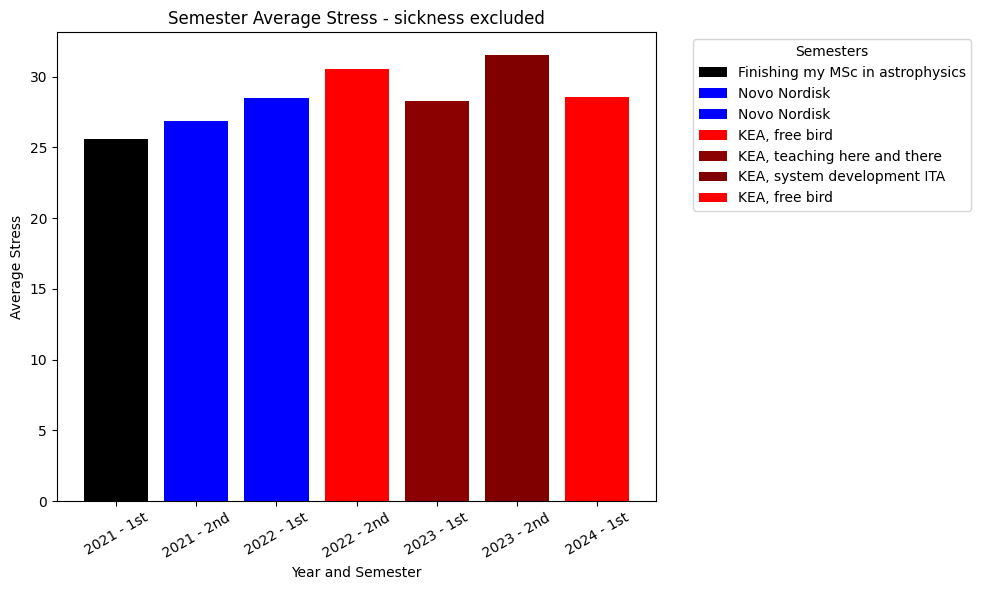

In [9]:
filtered_df = health_df[health_df['Sick'] == False]

# Now calculate the mean stress without including sick days
semester_stress_exclude_sick = filtered_df.groupby('YearSemester')['average_stress'].mean()

# Plotting stress levels
fig, ax = plt.subplots(figsize=(10, 6))
for index, value in semester_stress_exclude_sick.items():
    color = labels_colors[index][1]
    label = labels_colors[index][0]
    bar = ax.bar(index, value, color=color, label=label)

plt.title('Semester Average Stress - sickness excluded')
plt.xlabel('Year and Semester')
plt.ylabel('Average Stress')
plt.xticks(rotation=30)

# Handling the legend to display it outside the plot
plt.legend(title='Semesters', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend outside of the plot
plt.tight_layout()

plt.show()


### If relevant, talk about your machine-learning.
**TODO** We have used supporvised machinlearning algorithm for predicting how much strees predictivly could occour if sleep or alcohol were adjusted. 

### Genre. Which genre of data story did you use?
Our chosen genre aligns with the magazine-style approach. It is a written article, with plots supporting the story. Additionally, we have expanded this style to fit a more "Data Diary" approach. We have also chosen to tell the story in first person, giving it a more personal touch and, hopefully, making it more engaging for the reader.

### Which tools did you use from each of the 3 categories of Visual Narrative (Figure 7 in Segal and Heer). Why?


From the category "Visual Structuring" we have worked with keeping a **Consistent Visual Platform**. Its been backed up by the template used on Medium.
From the Highlightning category we have used the effect of **Zooming**. First we have focused on the overall stress level per. semester. Then we have focused on each element for weekdays. 
From the Transition guidence we have not used any tools.

### Which tools did you use from each of the 3 categories of Narrative Structure (Figure 7 in Segal and Heer). Why?

From the Ordering category we have used **User Directed Path**     
From the Interactivity category we have not used any.    
And last from the Messaging category we have worked with **Captions/Headlines, Accompanying Article, Introductory Text, Summary / Synthesis**    

## Visualizations.

### Explain the visualizations you've chosen.
In our article, we have used the plots shown below. In the actual article, a significant portion of the focus is on explaining the plots and what they mean. Therefore, we refer you to the article for detailed explanations.

The first plot we have used i ord article is the bar plot shown in section above "Describe your data analysis and explain what you've learned about the dataset."

**The second plot from the article:** "Weekly Average Stress Levels by Semester" 

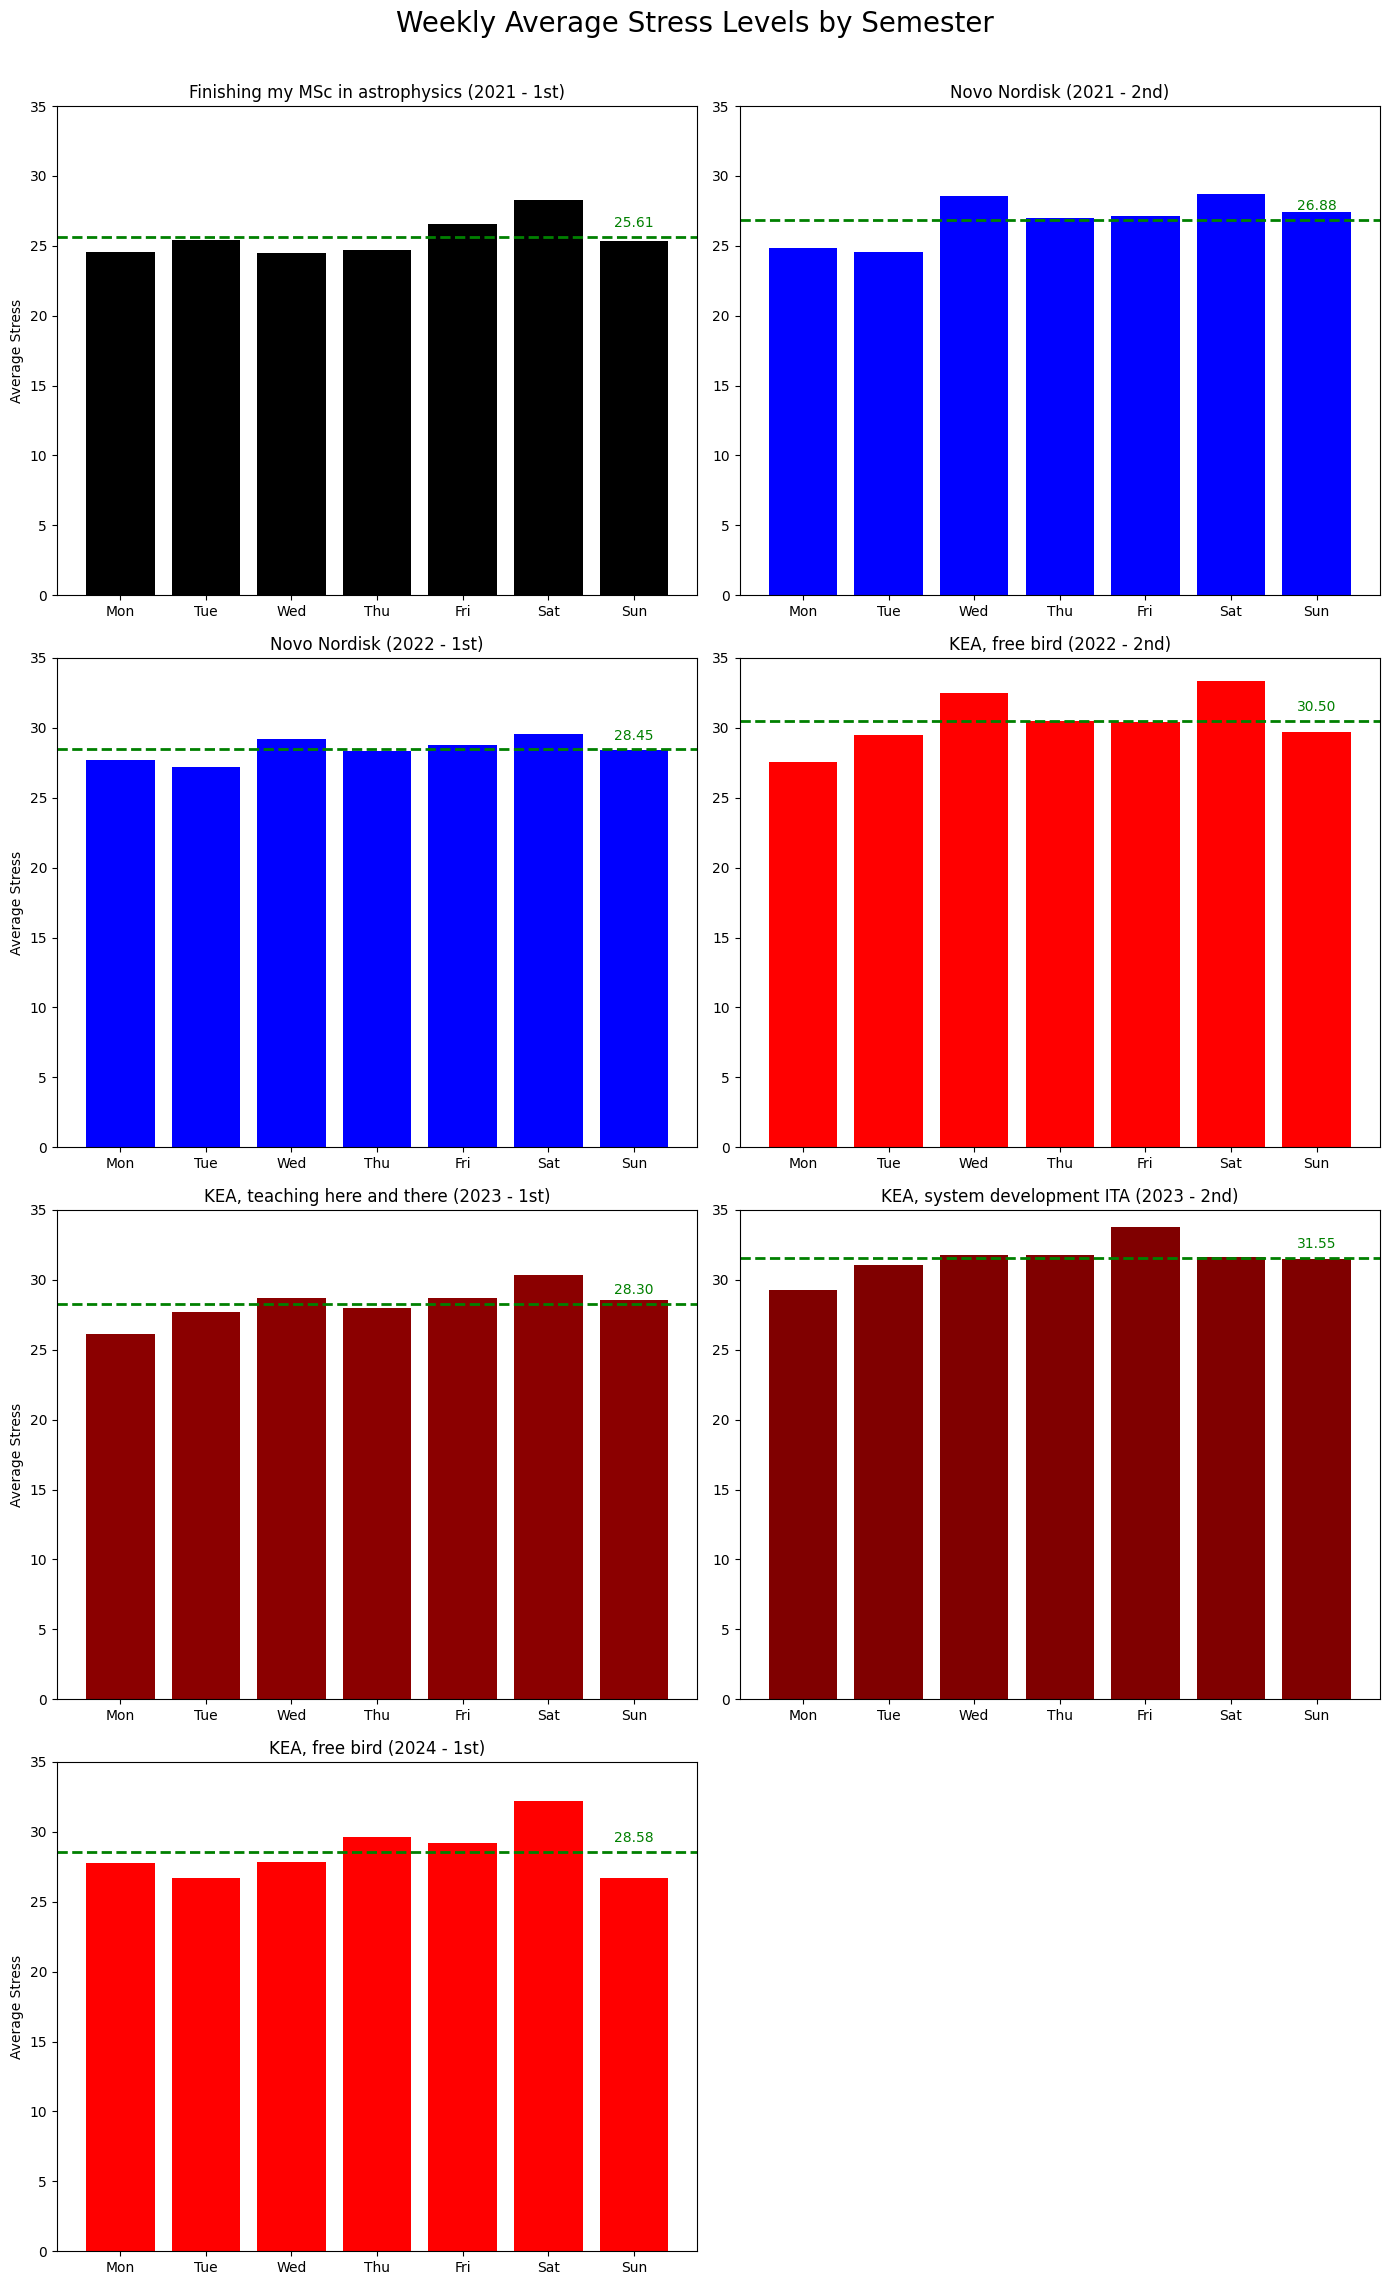

In [10]:
# Group by day of the week
weekday_stress = health_df['average_stress'].groupby(health_df.index.dayofweek).mean()
health_df['Weekday'] = health_df.index.dayofweek  # Add weekday information
health_df['Semester'] = health_df.index.month // 7 + 1  # Define semesters based on months
health_df['YearSemester'] = health_df.index.year.astype(str) + ' - ' + health_df['Semester'].replace({1: '1st', 2: '2nd'})

# Collect the average stress for each day of the week, for each semester
weekday_stress_per_semester = health_df.groupby(['YearSemester', 'Weekday'])['average_stress'].mean().unstack()
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 24))  # Adjusted for additional plots
fig.suptitle('Weekly Average Stress Levels by Semester', fontsize=20)

# Flatten axes for easy iteration
axes = axes.flatten()

# Number of semesters to plot
num_semesters = len(labels_colors)

# Total number of subplots (rows * columns)
total_plots = 4 * 2  # Update this based on the actual layout of nrows x ncols

# Plot each semester's data in a different subplot
for i, (semester, data) in enumerate(weekday_stress_per_semester.iterrows()):
    if i >= num_semesters:
        break  # Break if there are more subplots than semesters
    ax = axes[i]
    color = labels_colors[semester][1]
    ax.bar(x=data.index, height=data.values, color=color)
    ax.set_title(f"{labels_colors[semester][0]} ({semester})", fontsize=12)
    ax.set_xticks(range(7))
    ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    ax.set_ylabel('Average Stress' if i % 2 == 0 else '')
    ax.set_ylim(0, 35)
    mean_stress = data.mean()
    ax.axhline(y=mean_stress, color='green', linestyle='--', linewidth=2)
    ax.text(data.index[-1], mean_stress + 0.5, f'{mean_stress:.2f}', color='green', ha='center', va='bottom')

# Hide unused axes
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.subplots_adjust(top=0.94)  # Adjust this value to reduce the space after the title
plt.show()



**The third plot from the article:** "Comparison of Average Stress and Sleep on Weekdays vs. Weekends" 

In [11]:
# Assume 'Weekday' column exists with Monday as 0 through Sunday as 6
health_df['Day Type'] = health_df['Weekday'].apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculating mean, standard deviation, and CV for weekdays and weekends
day_type_summary = health_df.groupby('Day Type').agg({
    'resting_HR': ['mean', 'std', lambda x: np.std(x) / np.mean(x)],
    'average_stress': ['mean', 'std', lambda x: np.std(x) / np.mean(x)],
    'sleeping_hours': ['mean', 'std', lambda x: np.std(x) / np.mean(x)]
}).rename(columns={'<lambda_0>': 'CV'})

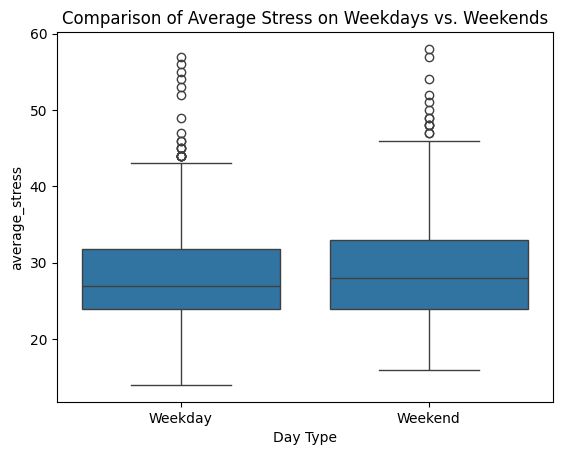

In [12]:
# Plotting the average stress levels by day type
sns.boxplot(x='Day Type', y='average_stress', data=health_df)
plt.title('Comparison of Average Stress on Weekdays vs. Weekends')
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

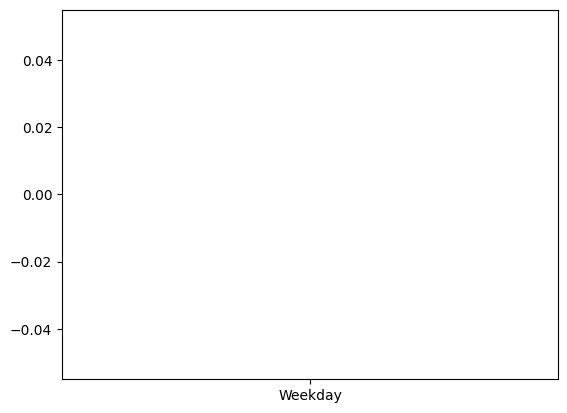

In [15]:
# Plotting the average stress levels by day type
sns.boxplot(x='Day Type', y='sleeping_hours', data=health_df)
plt.title('Comparison of Sleeping Hours on Weekdays vs. Weekends')
plt.show()

**The fouth plot from the article:** "Dayli Stress levels with Trends" 

In [19]:
health_df[health_df['Lecturing'] == 0]

# List of dates for Lecturing with little or no preparation
lecturing_dates_1 = pd.to_datetime(['2023-02-08', '2023-04-25', '2023-05-01', '2023-05-16', '2023-06-05', '2023-06-06', 
                     '2023-06-07', '2023-06-08', '2023-06-09', '2023-08-15', '2023-10-24', '2023-10-31',
                    '2023-02-27', '2023-03-06', '2023-03-13', '2023-03-20', '2023-03-27'])

# List of dates for Lecturing with preparation
lecturing_dates_2 = pd.to_datetime(['2021-04-23', '2022-11-11', '2023-02-17', '2023-02-26', '2023-03-21', '2023-04-18', '2023-04-21', '2023-09-05',
                     '2023-05-21', '2023-09-12', '2023-09-19', '2023-09-26', '2023-09-03', '2023-11-07', 
                     '2023-11-16', '2023-09-14', '2023-10-05', '2023-11-27', '2023-12-04'])

# Update for Lecturing
health_df.loc[health_df.index.isin(lecturing_dates_1), 'Lecturing'] = 1
health_df.loc[health_df.index.isin(lecturing_dates_2), 'Lecturing'] = 2




KeyError: 'Lecturing'

In [16]:
# Data preparation for plotting
categories = ['Normal', '2 Days prior to L1', 'Lecturing 1', '2 Days prior to L2', 'Lecturing 2']
stress_levels = [
    average_stress_normal,
    average_stress_pre_lecturing_1,
    average_stress_lecturing_1,
    average_stress_pre_lecturing_2,
    average_stress_lecturing_2
]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=categories, y=stress_levels, palette="viridis")
plt.title('Average Stress Comparison by Day Type')
plt.ylabel('Average Stress Level')
#plt.xlabel('Day Category')
plt.ylim(0, max(stress_levels) + 2)  # Set y-limit slightly higher than max for better visualization

# Annotate the bars with the exact stress levels for clarity
for i, v in enumerate(stress_levels):
    plt.text(i, v + 0.2, "{:.2f}".format(v), ha='center', va='baseline')

plt.show()


NameError: name 'average_stress_normal' is not defined

### Why are they right for the story you want to tell?
The story's aim is to communicate data to readers without any prior knowledge of data visualization. Our first visualization, a bar chart, was deliberately chosen to communicate the main points in an easy-to-understand way. The bar chart often has this quality, being intuitively easy to understand for an inexperienced reader. Later, we extended the story with different charts, such as a "box-and-whisker plot," "SHAP summary plot," and "scatter plots." Often, these require some explanation for the reader to understand the message. 

## Discussion. 
Think critically about your creation
* What went well?,
* What is still missing? What could be improved?, Why?

## Contributions. 
Who did what?
* You should write (just briefly) which group member was the main responsible for which elements of the assignment. (I want you guys to understand every part of the assignment, but usually there is someone who took lead role on certain portions of the work. That's what you should explain).
* It is not OK simply to write "All group members contributed equally".

Main responcibillities

**Magdalene Maria Otap**
* Medium article and Storyline

**Claus Bové**
* Explainer Notebook

## Make sure that you use references when they're needed and follow academic standards.




.









